# Phase Scan Effect on Antenna Voltage Unbalance
In this notebook we explore the effect of a phase scan over the voltage unbalance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from tqdm.notebook import tqdm

# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

In [3]:
# nicer plot
rf.stylely()

C:\Users\JH218595\Documents\scikit-rf\skrf\plotting.py:1441: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  mpl.style.use(os.path.join(pwd, style_file))


Let's use a TOPICA simulation of the WEST front face in a "L-mode plasma" at 55 MHz: 

In [10]:
freq = rf.Frequency(start=50, stop=60, npoints=1001, unit='MHz')
plasma_TOPICA = '../west_ic_antenna/data/Sparameters/front_faces/TOPICA/S_TSproto12_55MHz_Hmode_LAD6-2.5cm.s4p'

antenna = WestIcrhAntenna(frequency=freq, front_face=plasma_TOPICA)
print(f'Optimal coupling resistance expected:', antenna.front_face_Rc().max())

Optimal coupling resistance expected: 1.6095500081638645


First, we match the antenna, both sides at the same time to operate the antenna at 55 MHz. (In practice, both sides would have been matched at a lower frequency, and both sides operated in dipole at a higher frequency).

In [11]:
# antenna excitation to match for
power = [1, 1]  # W
phase = [0, np.pi]  # dipole

Cs = antenna.match_both_sides(f_match=55e6, power=power, phase=phase, solution_number=1)

Looking for individual solutions separately for 1st guess...
True solution #1: [53.55296321 46.40953769]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [53.17914232 46.56532157]
Searching for the active match point solution...
True solution #1: [54.14661525 46.73406685 53.85639844 46.90103987]


Let's visualize how good the antenna is matched for the target frequency, by looking to the active S parameters (ie. taking into account the antenna excitation)

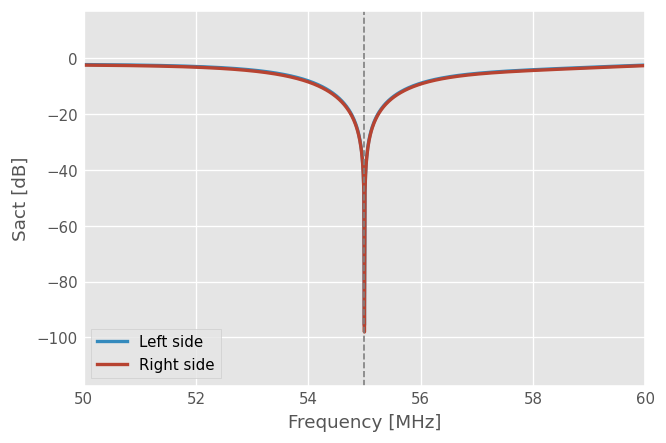

In [12]:
s_act = antenna.s_act(power=power, phase=phase, Cs=Cs)

fig, ax = plt.subplots()
ax.plot(antenna.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Sact [dB]')
ax.legend(('Left side', 'Right side'))
ax.axvline(55, ls='--', color='gray')

Now the antenna is perfeclty matched, let's see how the voltages evolve with frequency. At the match frequency, the voltages (and currents) get very close: the antenna is balanced.

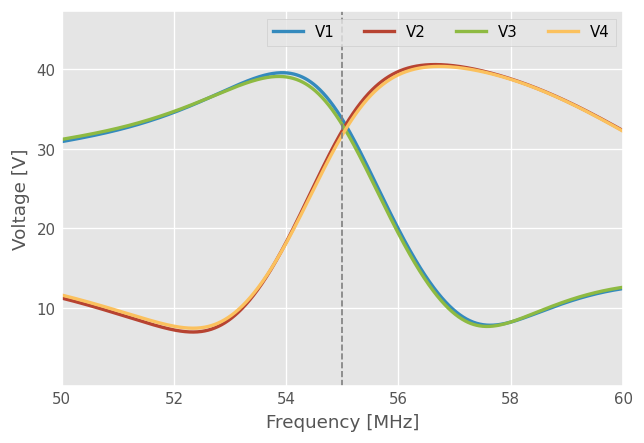

In [13]:
fig, ax = plt.subplots()
ax.plot(antenna.f_scaled, np.abs(antenna.voltages(power, phase, Cs)), lw=2)
ax.axvline(55, ls='--', color='gray')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Voltage [V]')
ax.legend(('V1', 'V2', 'V3', 'V4'), ncol=4)

 So let's see how the voltages evolve at the match frequency when we sweep the phase shift between sides:

In [14]:
power = [1e6, 1e6]  # 1 MW each side
toroidal_phases = np.deg2rad(np.linspace(start=0, stop=359, num=360))

In [15]:
antenna_single_freq = WestIcrhAntenna(frequency=rf.Frequency(55, 55, 1, unit='MHz'),
                                     front_face=plasma_TOPICA, Cs=Cs) 

voltages, currents, Rcs = [], [], []
for toroidal_phase in tqdm(toroidal_phases):
    voltages.append(antenna_single_freq.voltages(power, phase=[0, toroidal_phase]))
    currents.append(antenna_single_freq.voltages(power, phase=[0, toroidal_phase]))
    Rcs.append(antenna_single_freq.Rc_WEST(power, phase=[0, toroidal_phase]))
voltages = np.array(voltages).squeeze()
currents = np.array(currents).squeeze()
Rcs = np.array(Rcs).squeeze()

(0.0, 50.0)

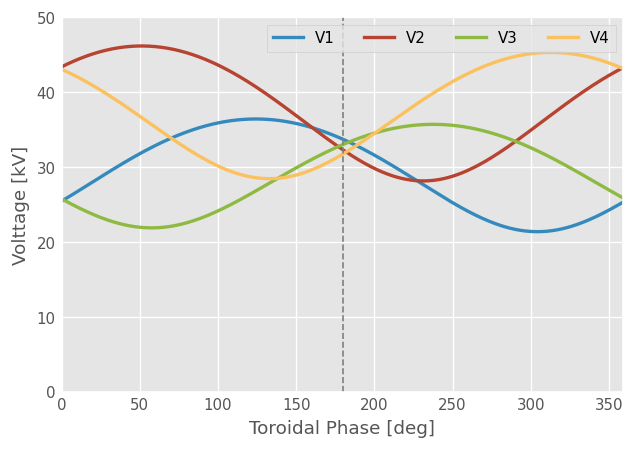

In [17]:
fig, ax = plt.subplots()
ax.plot(np.rad2deg(toroidal_phases), np.abs(voltages)/1e3, lw=2)
ax.axvline(180, ls='--', color='gray')
ax.set_xlabel('Toroidal Phase [deg]')
ax.set_ylabel('Volttage [kV]')
ax.legend(('V1', 'V2', 'V3', 'V4'), ncol=4)
ax.set_ylim(0,50)

The phase sweep generates voltage (or currents) unbalance.

The voltage probe toroidal phase difference is also slightly affected in this case:

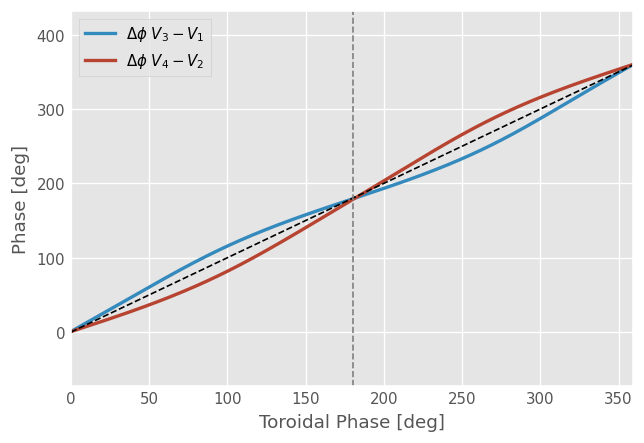

In [18]:
fig, ax = plt.subplots()
ax.plot(np.rad2deg(toroidal_phases), np.rad2deg(np.angle(voltages[:,2]) - np.angle(voltages[:,0]))%360, lw=2)
ax.plot(np.rad2deg(toroidal_phases), np.rad2deg(np.angle(voltages[:,3]) - np.angle(voltages[:,1]))%360, lw=2)
ax.plot(np.rad2deg(toroidal_phases), np.rad2deg(toroidal_phases), color='k', ls='--')
ax.axvline(180, ls='--', color='gray')
ax.set_xlabel('Toroidal Phase [deg]')
ax.set_ylabel('Phase [deg]')
ax.legend(('$\Delta  \phi$ $V_3-V_1$', '$\Delta  \phi$ $V_4-V_2$'))

Coupling resistance is also affected:

(0.0, 1.3)

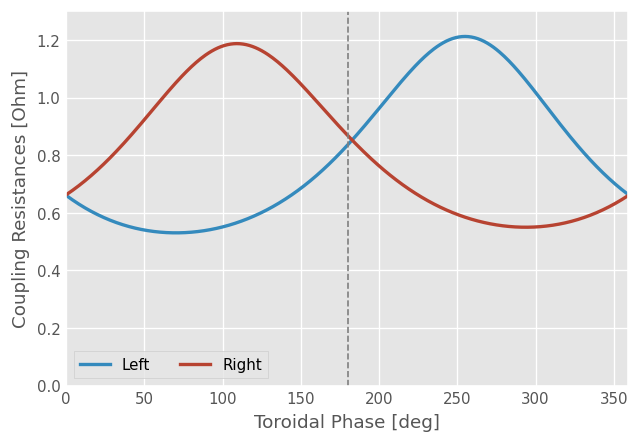

In [20]:
fig, ax = plt.subplots()
ax.plot(np.rad2deg(toroidal_phases), Rcs, lw=2)
ax.axvline(180, ls='--', color='gray')
ax.set_xlabel('Toroidal Phase [deg]')
ax.set_ylabel('Coupling Resistances [Ohm]')
ax.legend(('Left', 'Right'), ncol=4)
ax.set_ylim(0,1.3)

In [34]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')